## Cloth Classification Task
8 classes

In [1]:
import os
import torch
import time
import copy
import pandas as pd
import numpy as np
import random
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Visualize Data

In [2]:
train_frame = pd.read_csv('./data/train label.csv')

# check one photo
img_name = train_frame.iloc[7, 0]
classes = train_frame.iloc[:, 1].as_matrix()
classes = classes.astype('float').reshape(-1, 1)

print('Image name: {}'.format(img_name))
print('classes shape: {}'.format(classes.shape))
print('classes: {}'.format(classes[7]))

Image name: 1002906763_0.jpg
classes shape: (21048, 1)
classes: [ 0.]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


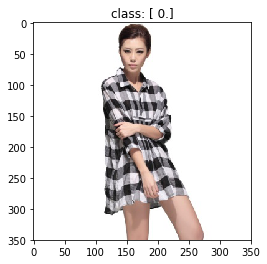

In [3]:
# show images
def show_image(images, label):
    plt.title('class: {}'.format(label))
    plt.imshow(images)
    
show_image(io.imread(os.path.join('./data/image/train/', img_name)), classes[7])

## Construct Dataset

In [4]:
class ClothDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, test=False):
        self.train_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.test = test
        
        if self.test:
            imgs = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        else:
            names = self.train_frame.iloc[:, 0]
            imgs = [os.path.join(root_dir, img) for img in names]
    
        self.imgs = imgs
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        if self.test == False:
            label = self.train_frame.iloc[idx, 1]
        else:
            label = -1
            
        image = Image.open(img_path)
        image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return image, label

### Check Dataset(train)

0 0
1 0
2 0
3 0


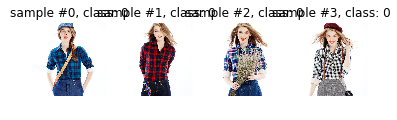

In [5]:
cloth_train_dataset = ClothDataset(csv_file='./data/train label.csv', root_dir='./data/image/train/', test=False)
fig = plt.figure()

for i in range(len(cloth_train_dataset)):
    image, label = cloth_train_dataset[i]
    
    print(i, label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    plt.imshow(image)
    
    if i == 3:
        plt.show()
        break

### Check Dataset(test)

0 -1
1 -1
2 -1
3 -1


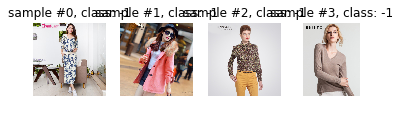

In [6]:
cloth_test_dataset = ClothDataset(csv_file='./data/train label.csv', root_dir='./data/image/test/', test=True)
fig = plt.figure()

for i in range(len(cloth_test_dataset)):
    image, label = cloth_test_dataset[i]
    
    print(i, label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    plt.imshow(image)
    
    if i == 3:
        plt.show()
        break

### Data Augmentation

In [7]:
# transform1
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4924044, 0.47831464, 0.44143882), (0.25063434, 0.2492162,  0.26660094))
])

# transform2
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4924044, 0.47831464, 0.44143882), (0.25063434, 0.2492162,  0.26660094))
])

### Test Transformation

In [8]:
full_dataset = ClothDataset(csv_file='./data/train label.csv', root_dir='./data/image/train/', test=False, transform=transform_train)
print(type(full_dataset[i]))
print('train_dataset size: ', len(full_dataset))

for i in range(len(full_dataset)):
    image, label = full_dataset[i]
    
    print(i, image.shape, label)
    
    if i == 3:
        break

<class 'tuple'>
train_dataset size:  21048
0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


## 划分训练集和校验集

In [9]:
validation_split=0.2
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Create data samples and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=30, sampler=train_sampler)
validation_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=30, sampler=valid_sampler)

print(type(train_dataloader))
print(type(validation_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [10]:
# combine train and validation into one dict
dataloaders = {'train': train_dataloader, 'val': validation_dataloader}
dataset_sizes = {'train': len(train_indices), 'val': len(val_indices)}
print(dataset_sizes['train'])

16839


In [11]:
test_dataset = ClothDataset(csv_file='./data/train label.csv', root_dir = './data/image/test/', test=True,transform= transform_test)
print(type(test_dataset[i]))

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    
    print(i, image.size(), label)
    
    if i == 3:
        break

<class 'tuple'>
0 torch.Size([3, 224, 224]) -1
1 torch.Size([3, 224, 224]) -1
2 torch.Size([3, 224, 224]) -1
3 torch.Size([3, 224, 224]) -1


### Show Batch Data

In [12]:
# show batch
def show_cloth_batch(images_batch, labels_batch):
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.title('Batch from dataloader')
        
for i_batch, (images_batch, labels_batch) in enumerate(dataloaders['train']):
    if i_batch == 1582:
        print(i_batch, images_batch.size(), labels_batch)
    
    if i_batch == 1582:
        plt.figure()
        show_cloth_batch(images_batch, labels_batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

<class 'torch.utils.data.dataloader.DataLoader'>
0 torch.Size([9, 3, 224, 224]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
1 torch.Size([9, 3, 224, 224]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
2 torch.Size([9, 3, 224, 224]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([9, 3, 224, 224]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])


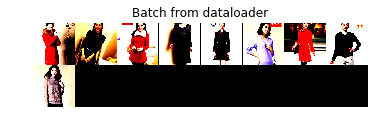

In [13]:
# use DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False)
print(type(test_dataloader))


def show_cloth_batch(images_batch, labels_batch):
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.title('Batch from dataloader')
        
for i_batch, (iamges_batch, labels_batch) in enumerate(test_dataloader):
    print(i_batch, images_batch.size(), labels_batch)
    
    if i_batch == 3:
        plt.figure()
        show_cloth_batch(images_batch, labels_batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Train Model

In [14]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y)
    plt.title("{} curve".format(title))
    plt.xlabel('epoch')
    plt.ylabel("{}".format(title))
    plt.show()

In [15]:
def save_model(model,filename):
    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()
    torch.save(state, filename)

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    # measure time
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and testing phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # train mode
            else:
                model.eval() # evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for i_batch, (images_batch, labels_batch) in enumerate(dataloaders[phase]):
                #print(type(sample_batched['image']))
                #print(type(sample_batched['has_cactus']))
                
                inputs = images_batch.to(device, dtype=torch.float)
                labels = labels_batch.to(device, dtype=torch.long)
                
                # labels = labels.resize(labels.size()[0])
                #print(labels.size())
                #print(labels)
                
                # zero gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print(outputs.size())
                    #print(labels.size())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistic
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            #print(running_loss)
            #print(running_corrects)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save best model weights up-to-date
                save_model(model, './model/densenet161_BEST.pt')
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    show_curve(train_loss, 'train_loss')
    show_curve(train_acc, 'train_acc')
    show_curve(val_loss, 'val_loss')
    show_curve(val_acc, 'val_acc')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize Model Prediction

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [18]:
# Visualize the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i_batch, (images_batch, labels_batch) in enumerate(dataloaders['val']):
            # Move to GPU
            inputs = images_batch.to(device, dtype=torch.float)
            labels = labels_batch.to(device, dtype=torch.long)
            # labels = labels.resize(labels.size()[0])
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                # show images
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predict: {}'.format(preds[j].item()))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

## Set Hyper-parameter

In [27]:
# Set Model
model_resnet152 = models.resnet152(pretrained=True)
num_ftrs = model_resnet152.fc.in_features
model_resnet152.fc = nn.Linear(num_ftrs, 8)


# Set Parameters
lr = 0.01
momentum = 0.9
step_size=10
gamma=0.1
num_epochs=60

# Set GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Prepare Training

### resnet18

In [28]:
model = model_resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/29
----------
train Loss: 2.1589 Acc: 0.2325
val Loss: 1.9579 Acc: 0.2770

Epoch 1/29
----------
train Loss: 1.9061 Acc: 0.2690
val Loss: 2.4401 Acc: 0.3039

Epoch 2/29
----------
train Loss: 1.7834 Acc: 0.3187
val Loss: 1.6492 Acc: 0.3801

Epoch 3/29
----------
train Loss: 1.6064 Acc: 0.4074
val Loss: 1.4809 Acc: 0.4676

Epoch 4/29
----------
train Loss: 1.3575 Acc: 0.5004
val Loss: 1.1775 Acc: 0.5925

Epoch 5/29
----------
train Loss: 1.1505 Acc: 0.5844
val Loss: 0.9682 Acc: 0.6557

Epoch 6/29
----------
train Loss: 1.0078 Acc: 0.6415
val Loss: 0.9328 Acc: 0.6781

Epoch 7/29
----------
train Loss: 0.8982 Acc: 0.6786
val Loss: 0.8785 Acc: 0.6954

Epoch 8/29
----------
train Loss: 0.8170 Acc: 0.7073
val Loss: 0.8057 Acc: 0.7180

Epoch 9/29
----------
train Loss: 0.7433 Acc: 0.7388
val Loss: 0.7282 Acc: 0.7427

Epoch 10/29
----------
train Loss: 0.5691 Acc: 0.7975
val Loss: 0.6032 Acc: 0.7962

Epoch 11/29
----------
train Loss: 0.5276 Acc: 0.8132
val Loss: 0.5806 Acc: 0.7995

Ep

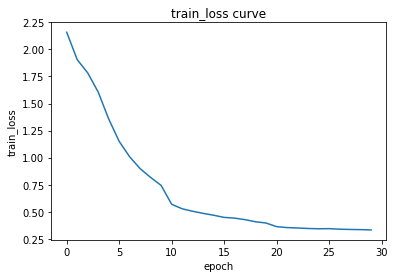

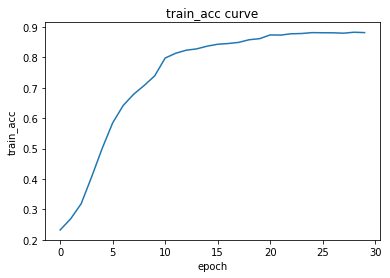

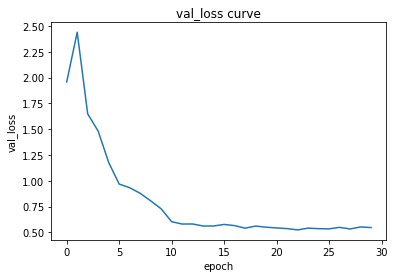

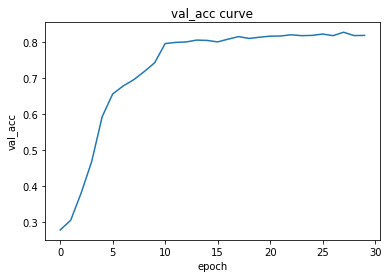

In [85]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

### resnet50

In [22]:
model = model_resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/59
----------
train Loss: 1.9914 Acc: 0.2510
val Loss: 1.9002 Acc: 0.2761

Epoch 1/59
----------
train Loss: 1.8823 Acc: 0.2765
val Loss: 1.7650 Acc: 0.3443

Epoch 2/59
----------
train Loss: 1.7483 Acc: 0.3298
val Loss: 1.9698 Acc: 0.2806

Epoch 3/59
----------
train Loss: 1.5536 Acc: 0.4215
val Loss: 1.3462 Acc: 0.5032

Epoch 4/59
----------
train Loss: 1.3389 Acc: 0.5029
val Loss: 1.2648 Acc: 0.5579

Epoch 5/59
----------
train Loss: 1.1411 Acc: 0.5800
val Loss: 1.0659 Acc: 0.6218

Epoch 6/59
----------
train Loss: 1.0031 Acc: 0.6430
val Loss: 1.3004 Acc: 0.5336

Epoch 7/59
----------
train Loss: 0.9136 Acc: 0.6760
val Loss: 0.9093 Acc: 0.6793

Epoch 8/59
----------
train Loss: 0.8186 Acc: 0.7091
val Loss: 0.7745 Acc: 0.7332

Epoch 9/59
----------
train Loss: 0.7555 Acc: 0.7323
val Loss: 0.7326 Acc: 0.7439

Epoch 10/59
----------
train Loss: 0.5886 Acc: 0.7902
val Loss: 0.5729 Acc: 0.8033

Epoch 11/59
----------
train Loss: 0.5405 Acc: 0.8084
val Loss: 0.5697 Acc: 0.8066

Ep

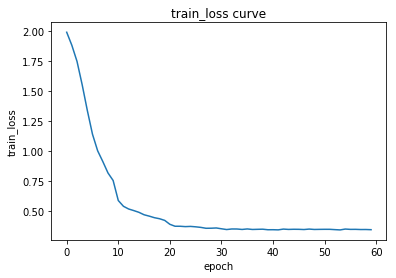

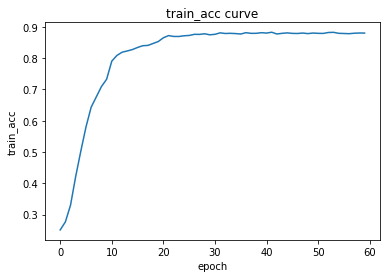

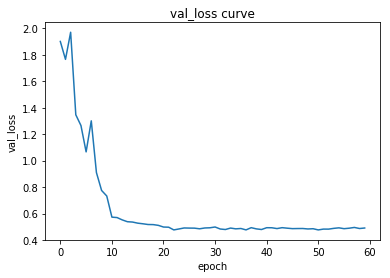

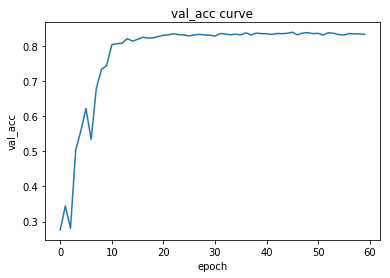

In [23]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

### resnet152

In [29]:
model = model_resnet152.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/59
----------
train Loss: 1.9949 Acc: 0.2482
val Loss: 1.9763 Acc: 0.2542

Epoch 1/59
----------
train Loss: 1.9304 Acc: 0.2631
val Loss: 1.8670 Acc: 0.2927

Epoch 2/59
----------
train Loss: 1.8898 Acc: 0.2722
val Loss: 1.8771 Acc: 0.2901

Epoch 3/59
----------
train Loss: 1.8583 Acc: 0.2866
val Loss: 2.0641 Acc: 0.2944

Epoch 4/59
----------
train Loss: 1.7992 Acc: 0.3213
val Loss: 1.8237 Acc: 0.3229

Epoch 5/59
----------
train Loss: 1.6977 Acc: 0.3688
val Loss: 1.5516 Acc: 0.4345

Epoch 6/59
----------
train Loss: 1.5263 Acc: 0.4360
val Loss: 1.3271 Acc: 0.5153

Epoch 7/59
----------
train Loss: 1.3212 Acc: 0.5209
val Loss: 1.2107 Acc: 0.5676

Epoch 8/59
----------
train Loss: 1.1687 Acc: 0.5761
val Loss: 1.1052 Acc: 0.6006

Epoch 9/59
----------
train Loss: 1.0499 Acc: 0.6237
val Loss: 0.9143 Acc: 0.6852

Epoch 10/59
----------
train Loss: 0.8109 Acc: 0.7122
val Loss: 0.7818 Acc: 0.7211

Epoch 11/59
----------
train Loss: 0.7465 Acc: 0.7337
val Loss: 0.7379 Acc: 0.7382

Ep

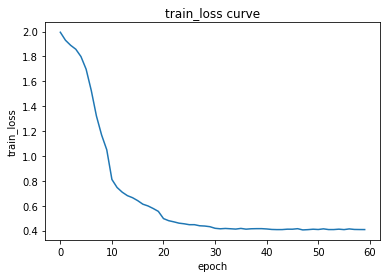

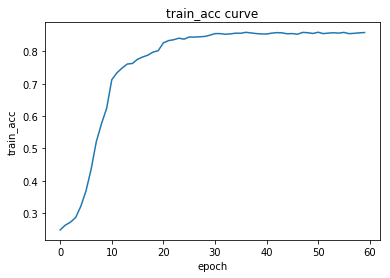

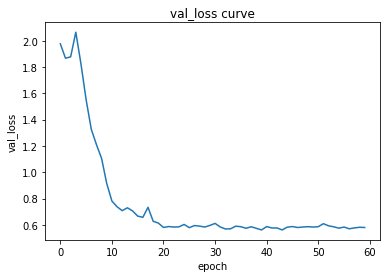

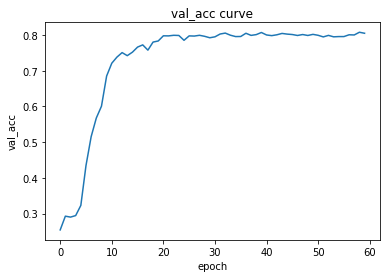

In [30]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

### DenseNet161

In [19]:
# Set Model
model_densenet161 = models.densenet161(pretrained=True)
num_ftrs = model_densenet161.classifier.in_features
model_densenet161.classifier = nn.Linear(num_ftrs, 8)


# Set Parameters
lr = 0.001
momentum = 0.9
step_size=10
gamma=0.1
num_epochs=30

# Set GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

/opt/conda/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


cuda:0


In [20]:
model = model_densenet161.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/29
----------
train Loss: 0.6670 Acc: 0.7745
val Loss: 0.3705 Acc: 0.8784

Epoch 1/29
----------
train Loss: 0.3554 Acc: 0.8808
val Loss: 0.3313 Acc: 0.8917

Epoch 2/29
----------
train Loss: 0.2633 Acc: 0.9125
val Loss: 0.3423 Acc: 0.8848

Epoch 3/29
----------
train Loss: 0.2027 Acc: 0.9309
val Loss: 0.3527 Acc: 0.8819

Epoch 4/29
----------
train Loss: 0.1584 Acc: 0.9464
val Loss: 0.3377 Acc: 0.8902

Epoch 5/29
----------
train Loss: 0.1227 Acc: 0.9587
val Loss: 0.3572 Acc: 0.8852

Epoch 6/29
----------
train Loss: 0.0903 Acc: 0.9709
val Loss: 0.3761 Acc: 0.8895

Epoch 7/29
----------
train Loss: 0.0742 Acc: 0.9759
val Loss: 0.3946 Acc: 0.8886

Epoch 8/29
----------
train Loss: 0.0641 Acc: 0.9793
val Loss: 0.4171 Acc: 0.8909

Epoch 9/29
----------
train Loss: 0.0544 Acc: 0.9835
val Loss: 0.4056 Acc: 0.8881

Epoch 10/29
----------
train Loss: 0.0349 Acc: 0.9912
val Loss: 0.3865 Acc: 0.8936

Epoch 11/29
----------
train Loss: 0.0261 Acc: 0.9937
val Loss: 0.4044 Acc: 0.8909

Ep

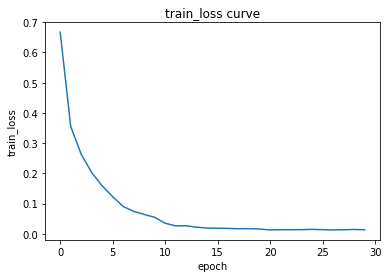

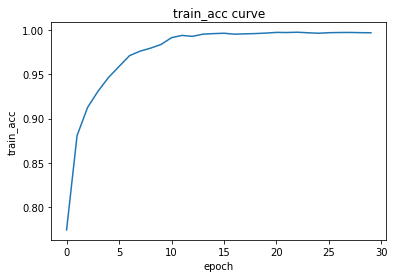

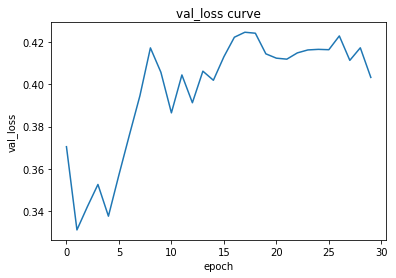

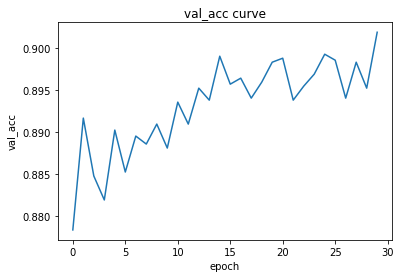

In [21]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

## Predict

In [19]:
def predict(model, test_dataloader):
    result = []
    with torch.no_grad():
         for i_batch, (images_batch, labels_batch) in enumerate(test_dataloader):
            # Move to GPU
            inputs = images_batch.to(device, dtype=torch.float)
            labels = labels_batch.to(device, dtype=torch.long)
            # labels = labels.resize(labels.size()[0])
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            
            # print(type(preds))
            # print(preds)
            preds_np = preds.cpu().numpy()
            # print(preds_np)
            result = np.append(result, preds_np)
            
            # print(result)
            
            if (i_batch == 2000):
                print('2000 batches')
            elif i_batch == 4000:
                print('4000 batches')
    
    return result

In [20]:
# Set Model
model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 8)
checkpoint = torch.load('./model/resnet50_BEST.pt')
model_resnet50.load_state_dict(checkpoint)

model = model_resnet50.to(device)

In [21]:
result = predict(model, test_dataloader)

In [22]:
print(type(result))
print(result.shape)

<class 'numpy.ndarray'>
(4500,)


In [23]:
img_idx = os.listdir('./data/image/test/')
print(img_idx)
img_idx = prediction.iloc[:, 0]
print(img_idx)

['1257194670_0.jpg', '1331669067_0.jpg', '1030031690_0.jpg', '1042079939_0.jpg', '1392549927_0.jpg', '1219369112_0.jpg', '1074414124_0.jpg', '1022435684_0.jpg', '1382318481_0.jpg', '1109736123_0.jpg', '1049622193_0.jpg', '1029862130_0.jpg', '1445565607_0.jpg', '1454956234_0.jpg', '1004558638_0.jpg', '1477572864_0.jpg', '1797314050_0.jpg', '1054664399_0.jpg', '1087983100_0.jpg', '1156694115_0.jpg', '1187166366_0.jpg', '1344869062_0.jpg', '1411108444_0.jpg', '1500368012_0.jpg', '1111112171_0.jpg', '1166941378_0.jpg', '1246367092_0.jpg', '1350177495_0.jpg', '10056013380_0.jpg', '1121574657_0.jpg', '1303850620_0.jpg', '1102712669_0.jpg', '1205757170_0.jpg', '1036523237_0.jpg', '1324702294_0.jpg', '1392129959_0.jpg', '1359907332_0.jpg', '1478486268_0.jpg', '1389461157_0.jpg', '1095502819_0.jpg', '1722904135_0.jpg', '1029194300_0.jpg', '1539907962_0.jpg', '1409573292_0.jpg', '1485571905_0.jpg', '1146838255_0.jpg', '1101318621_0.jpg', '1314149812_0.jpg', '1146567724_0.jpg', '1262301524_0.jpg'

NameError: name 'prediction' is not defined

In [24]:
classify_result = pd.DataFrame({'Image': img_idx, 'Cloth_label': result.astype(np.int32)})
print(classify_result)

                  Image  Cloth_label
0      1257194670_0.jpg            1
1      1331669067_0.jpg            6
2      1030031690_0.jpg            0
3      1042079939_0.jpg            7
4      1392549927_0.jpg            7
5      1219369112_0.jpg            7
6      1074414124_0.jpg            3
7      1022435684_0.jpg            5
8      1382318481_0.jpg            7
9      1109736123_0.jpg            5
10     1049622193_0.jpg            3
11     1029862130_0.jpg            6
12     1445565607_0.jpg            4
13     1454956234_0.jpg            3
14     1004558638_0.jpg            1
15     1477572864_0.jpg            5
16     1797314050_0.jpg            0
17     1054664399_0.jpg            7
18     1087983100_0.jpg            4
19     1156694115_0.jpg            3
20     1187166366_0.jpg            1
21     1344869062_0.jpg            3
22     1411108444_0.jpg            3
23     1500368012_0.jpg            5
24     1111112171_0.jpg            1
25     1166941378_0.jpg            1
2

In [25]:
classify_result.to_csv('./result/result_resnet50.csv', index=False)